<a href="https://colab.research.google.com/github/youjinchang/SportAnalysis/blob/main/SIS5203_41_week11_model_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SIS5203 수업을 위한 자료입니다.

### 작업환경 확인

In [ ]:
# 현재 위치 확인
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
#https://stackoverflow.com/a/53586419
import sys
IN_COLAB = 'google.colab' in sys.modules
print(IN_COLAB)

True


In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/MyDrive/Colab Notebooks') # 본인 코랩 노트북 경로 맞추기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

a7ba5971871d


## 필요 라이브러리 import

In [ ]:
%matplotlib inline
import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

In [ ]:
np.random.seed(1214)

In [ ]:
print(tf.__version__) #2.3.0 에서 테스트됨

2.8.0


## 데이터 불러오기

In [ ]:
loadFromPickle = True  #True #False

In [ ]:
outdir_pickle = './pickle'
fn_pickle_pub = '{}/Dataset_SIS5203_OS_class4_len100_pub.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

./pickle/Dataset_SIS5203_OS_class4_len100_pub.pickle


In [ ]:
os.path.exists(fn_pickle_pub)

True

In [ ]:

if os.path.exists(fn_pickle_pub):
    print('{} exists....OK'.format(fn_pickle_pub))

    print('load from pickle files')
    file = open(fn_pickle_pub, 'rb')
    data = pickle.load(file)
    file.close()

    data_training = data[0]
    labels_training = data[1]
    data_test = data[2]
    labels_test = data[3] 
    class_name = data[4] 
    features_name = data[5]
    vtt_avg = data[6] 
    dname = data[7]
    tstring = data[8]
    scaler = data[9]
    sz_train = data[10]
    sz_test = data[11]

print(np.shape(labels_training), np.shape(labels_test))

./pickle/Dataset_SIS5203_OS_class4_len100_pub.pickle exists....OK
load from pickle files
(13400, 4) (6030, 4)


In [ ]:
n_outputs = len(class_name)
n_timesteps = np.shape(data_training)[1]
n_features = len(features_name)
print('n_outputs(n_classes) :',n_outputs)
print('n_features(datadim) :', n_features)
print('n_timesteps(sequence_length) :', n_timesteps)
print('class_name :', class_name)
print('features_name :', features_name)
print('vtt_avg :', vtt_avg)

n_outputs(n_classes) : 4
n_features(datadim) : 9
n_timesteps(sequence_length) : 100
class_name : ['C00', 'C01', 'C02', 'C03']
features_name : ['acc_x' 'acc_y' 'acc_z' 'ang_x' 'ang_y' 'ang_z' 'lacc_x' 'lacc_y'
 'lacc_z']
vtt_avg : [array([9.87076668]), array([9.83035598]), array([9.79788384]), array([9.81366063])]


In [ ]:
trainX = data_training
trainy = labels_training
testX = data_test
testy = labels_test

In [ ]:
print ('======================')
print ('Data : ', trainX.shape)
print ('Label : ', trainy.shape)
print ('======================')

print ('Data : ', testX.shape)
print ('Label : ', testy.shape)
print ('======================')

Data :  (13400, 100, 9)
Label :  (13400, 4)
Data :  (6030, 100, 9)
Label :  (6030, 4)


In [ ]:
print(n_timesteps, n_features, n_outputs)

100 9 4


## 학습

In [ ]:
to_Train = True

In [ ]:
num_layers = 2  
training_epochs = 100
batch_size = 100 

In [ ]:
celltype = 1
cellName = ('GRU', 'Conv1D')
cell_name = cellName[celltype]

mltype = cellName[celltype]

costType = 1  # 0 for MSE, 1 for CEE
costName = ('MSE', 'CEE')
cname = costName[costType]
print('{}, {}'.format(cellName[celltype], cname))

Conv1D, CEE


In [ ]:
if hostname=="devbox20":
    base_dir_out = './out'
elif hostname=="spacegray":   
    base_dir_out = '/home/seung/data/out-hyejoo-21July/'
else:
    base_dir_out = './out'
    
outDir = '{}/n21_CL{}_HL{}_{}_EP{}_{}_len{}'.format(base_dir_out ,n_outputs, num_layers, cellName[celltype], training_epochs, cname, n_timesteps)
#outDir2 = './out_plot'

#-datadim
ttl1 = 'SQ{}_C{}_Dim{}_HL{}_{}_EP{}_{}_len{}'.format(n_timesteps, n_outputs, n_features, num_layers, cellName[celltype], training_epochs, cname, n_timesteps)
fnbasis = 'N_to_1_'+ttl1
fnmodel = outDir+'/model_RNN_'+fnbasis+'.h5'
print(fnmodel)
fnmodel2 = outDir+'/model2_RNN_'+fnbasis+'.h5'
print(fnmodel2)

./out/n21_CL4_HL2_Conv1D_EP100_CEE_len100/model_RNN_N_to_1_SQ100_C4_Dim9_HL2_Conv1D_EP100_CEE_len100.h5
./out/n21_CL4_HL2_Conv1D_EP100_CEE_len100/model2_RNN_N_to_1_SQ100_C4_Dim9_HL2_Conv1D_EP100_CEE_len100.h5


In [ ]:
def Makedir(path):
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)

In [ ]:
if not to_Train:
    if not os.path.isfile(fnmodel):
        to_Train = True
        print('Model file {} not exists !!'.format(fnmodel))
        print('Setting to_Train --> {}'.format(to_Train))

    else:
        print('Model file Okay : {}  !!'.format(fnmodel))

Makedir(outDir)
print('Created {}'.format(outDir))

#MakeDir(outDir2)

Created ./out/n21_CL4_HL2_Conv1D_EP100_CEE_len100


In [ ]:
print(celltype, cellName[celltype])

1 Conv1D


In [ ]:
if celltype==0:
    model = Sequential()
    model.add(GRU(n_timesteps, return_sequences=True, input_shape=(n_timesteps,n_features)))
    model.add(GRU(n_timesteps))
    model.add(Dropout(rate=0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
elif celltype==1:
    model = Sequential()
    model.add(Conv1D(kernel_size=3, strides=1,filters=32, activation='relu', padding='same', input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(kernel_size=3, strides=1,filters=64, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=0.2)) #rate = 1 - keep_prob
    model.add(Dense(64, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))

In [ ]:
print(model.summary())  # LSTMb 로 진행할 때는 오류남 넘어갈 것

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           896       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                        

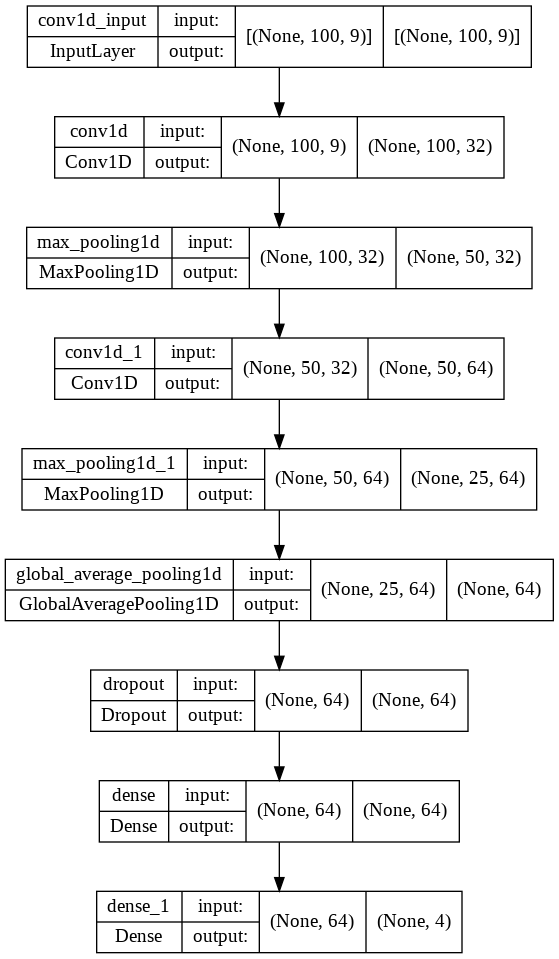

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='{}/model{}.png'.format(outDir, ttl1), show_shapes=True)

from IPython.display import Image
Image('{}/model{}.png'.format(outDir, ttl1))

In [ ]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr_schedule(0)), metrics=['accuracy'])

Learning rate:  0.001


In [ ]:
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [ ]:
filepath = os.path.join(outDir, 'model')
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

In [ ]:
callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
# fit network
if to_Train:
    verbose = 1
    history = model.fit(trainX, trainy, epochs=training_epochs, batch_size=batch_size, verbose=verbose, validation_data=(testX, testy),  callbacks=callbacks)
    model.save(fnmodel)
    print('Saved model..... {}'.format(fnmodel))
else:
    model = load_model(fnmodel)
    print('Loaded model..... {}'.format(fnmodel))

Learning rate:  0.001
Epoch 1/100
134/134 [==============================] - 5s 30ms/step - loss: 0.8731 - accuracy: 0.6104 - val_loss: 0.6051 - val_accuracy: 0.7723 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
134/134 [==============================] - 4s 26ms/step - loss: 0.5750 - accuracy: 0.7681 - val_loss: 0.4802 - val_accuracy: 0.8270 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
134/134 [==============================] - 3s 25ms/step - loss: 0.4764 - accuracy: 0.8231 - val_loss: 0.4094 - val_accuracy: 0.8529 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
134/134 [==============================] - 4s 26ms/step - loss: 0.4078 - accuracy: 0.8496 - val_loss: 0.3529 - val_accuracy: 0.8721 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
134/134 [==============================] - 4s 26ms/step - loss: 0.3563 - accuracy: 0.8733 - val_loss: 0.3296 - val_accuracy: 0.8811 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
134/134 [==============================] - 3s 26ms/step - loss: 0.3310 

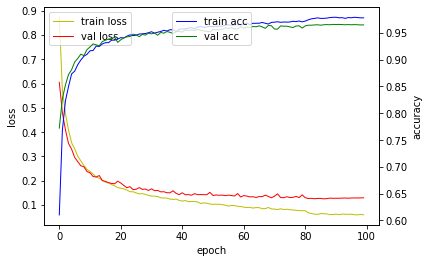

In [ ]:
if to_Train:
    if tf.__version__=='2.3.0':
        key_acc = 'accuracy'
        key_acc_val = 'val_accuracy'
    else:
        key_acc = 'accuracy'
        key_acc_val = 'val_accuracy'
    
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss', linewidth=1)
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss', linewidth=1)
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history[key_acc], 'b', label='train acc', linewidth=1)
    acc_ax.plot(history.history[key_acc_val], 'g', label='val acc', linewidth=1)
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')

## 결과

In [ ]:
trainX.shape, trainy.shape

((13400, 100, 9), (13400, 4))

In [ ]:
pred_train = model.predict(trainX, verbose=1)
pred_test = model.predict(testX, verbose=1)

189/189 [==============================] - 1s 4ms/step


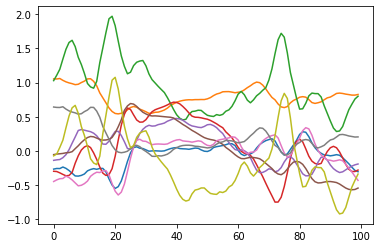

In [ ]:
plt.plot(testX[0])
plt.show()

In [ ]:
trainy1 = np.argmax(trainy, axis=1)
pred_train1 = np.argmax(pred_train, axis=1)

In [ ]:
testy1 = np.argmax(testy, axis=1)
pred_test1 = np.argmax(pred_test, axis=1)

In [ ]:
from sklearn.metrics import classification_report
print(cellName[celltype],'Train result')
print(classification_report(trainy1, pred_train1, digits=4))   #classification_report( y_true , y_pred)

Conv1D Train result
              precision    recall  f1-score   support

           0     0.9907    0.9917    0.9912      4200
           1     0.9994    0.9985    0.9990      3400
           2     0.9870    0.9761    0.9815      2800
           3     0.9782    0.9880    0.9831      3000

    accuracy                         0.9893     13400
   macro avg     0.9888    0.9886    0.9887     13400
weighted avg     0.9893    0.9893    0.9893     13400



In [ ]:
print(cellName[celltype],'Test result')
print(classification_report(testy1, pred_test1, digits=4))

Conv1D Test result
              precision    recall  f1-score   support

           0     0.9663    0.9663    0.9663      1900
           1     0.9949    0.9929    0.9939      1560
           2     0.9456    0.9417    0.9436      1200
           3     0.9456    0.9511    0.9483      1370

    accuracy                         0.9648      6030
   macro avg     0.9631    0.9630    0.9630      6030
weighted avg     0.9649    0.9648    0.9649      6030



In [ ]:
# 모델 평가
print(model.metrics_names)
score0 = model.evaluate(trainX, trainy, verbose=1)
score = model.evaluate(testX, testy, verbose=1)

#print(score0)
#print('Train score:', score0[0])
print('Train accuracy:', score0[1])

#print(score)
#print('Test score:', score[0])
print('Test accuracy:', score[1])

['loss', 'accuracy']
189/189 [==============================] - 1s 4ms/step - loss: 0.1293 - accuracy: 0.9648
Train accuracy: 0.9893283843994141
Test accuracy: 0.9648424386978149


In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
from sklearn.metrics import f1_score

# 'micro', 'macro', 'weighted'

f1 = f1_score(trainy1, pred_train1, average='weighted')
f11 = f1_score(testy1, pred_test1, average='weighted')

print('Train f1-score: ',f1)
print('Test f1-score: ',f11)

Train f1-score:  0.9893270985792691
Test f1-score:  0.9648518463998758


In [ ]:
conf_matrix = pd.crosstab(trainy1, pred_train1) #행(row)이 정답, 열(col)이 맞춘거
print(conf_matrix)

col_0     0     1     2     3
row_0                        
0      4165     0    14    21
1         2  3395     1     2
2        23     1  2733    43
3        14     1    21  2964


In [ ]:
conf_matrix = pd.crosstab(testy1, pred_test1) 
print(conf_matrix)

col_0     0     1     2     3
row_0                        
0      1836     4    29    31
1         4  1549     3     4
2        28     2  1130    40
3        32     2    33  1303


In [ ]:
outdir = ''
ttl1fn = '{}_'.format(cell_name)
ttl1fn = ttl1fn.replace(' ', '')
print(ttl1fn)

Conv1D_


In [ ]:
def plot_confusion_matrix3x(actual, predicted, classes, title='Confusion Matrix', normalize=False, hide_classname = False, 
                            figsize=(4, 4), dpi=36, cmap=plt.cm.viridis, outdir=outDir):
    import itertools
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    if not normalize:
        conf_matrix = pd.crosstab(actual, predicted) 
    else:
        conf_matrix = pd.crosstab(actual, predicted).apply(lambda r: r / r.sum(), axis=1)
        
    if np.shape(conf_matrix) != (len(classes), len(classes)):
        print(np.shape(conf_matrix))
        for i in range(len(classes)):
            if i not in conf_matrix.columns:
                conf_matrix[i] = 0.00
        conf_matrix = conf_matrix[[i for i in range(len(classes))]]

    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    
    ax = plt.gca()
    im = ax.imshow(conf_matrix, aspect=1.0, interpolation='nearest',cmap=cmap)
    
    plt.title(title, size=12)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05, aspect=20)
    plt.colorbar(im, cax=cax)
    
    
    if hide_classname:
        classes2 = []
        for k, _ in enumerate(classes):
            classes2.append('C{}'.format(k))
        classes = classes2
    
    tick_marks = np.arange(len(classes))

    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=9) 
    ax.set_xticklabels(classes, fontsize=9, rotation=90)
    
   
    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    thresh = 0.5
    
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        if conf_matrix[j][i] > thresh: #thresh[j]:
            color="white" 
        
        else :
            color = "black"  
        ax.text(j, i, format(conf_matrix[j][i], fmt), ha="center", va="center", color=color, fontsize=10)  #14  
        
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.grid(False)
    plt.savefig('{}/final_{}.png'.format(outdir, title), bbox_inches='tight')
    plt.savefig('{}/final_{}.svg'.format(outdir, title), bbox_inches='tight')
    
    return fig

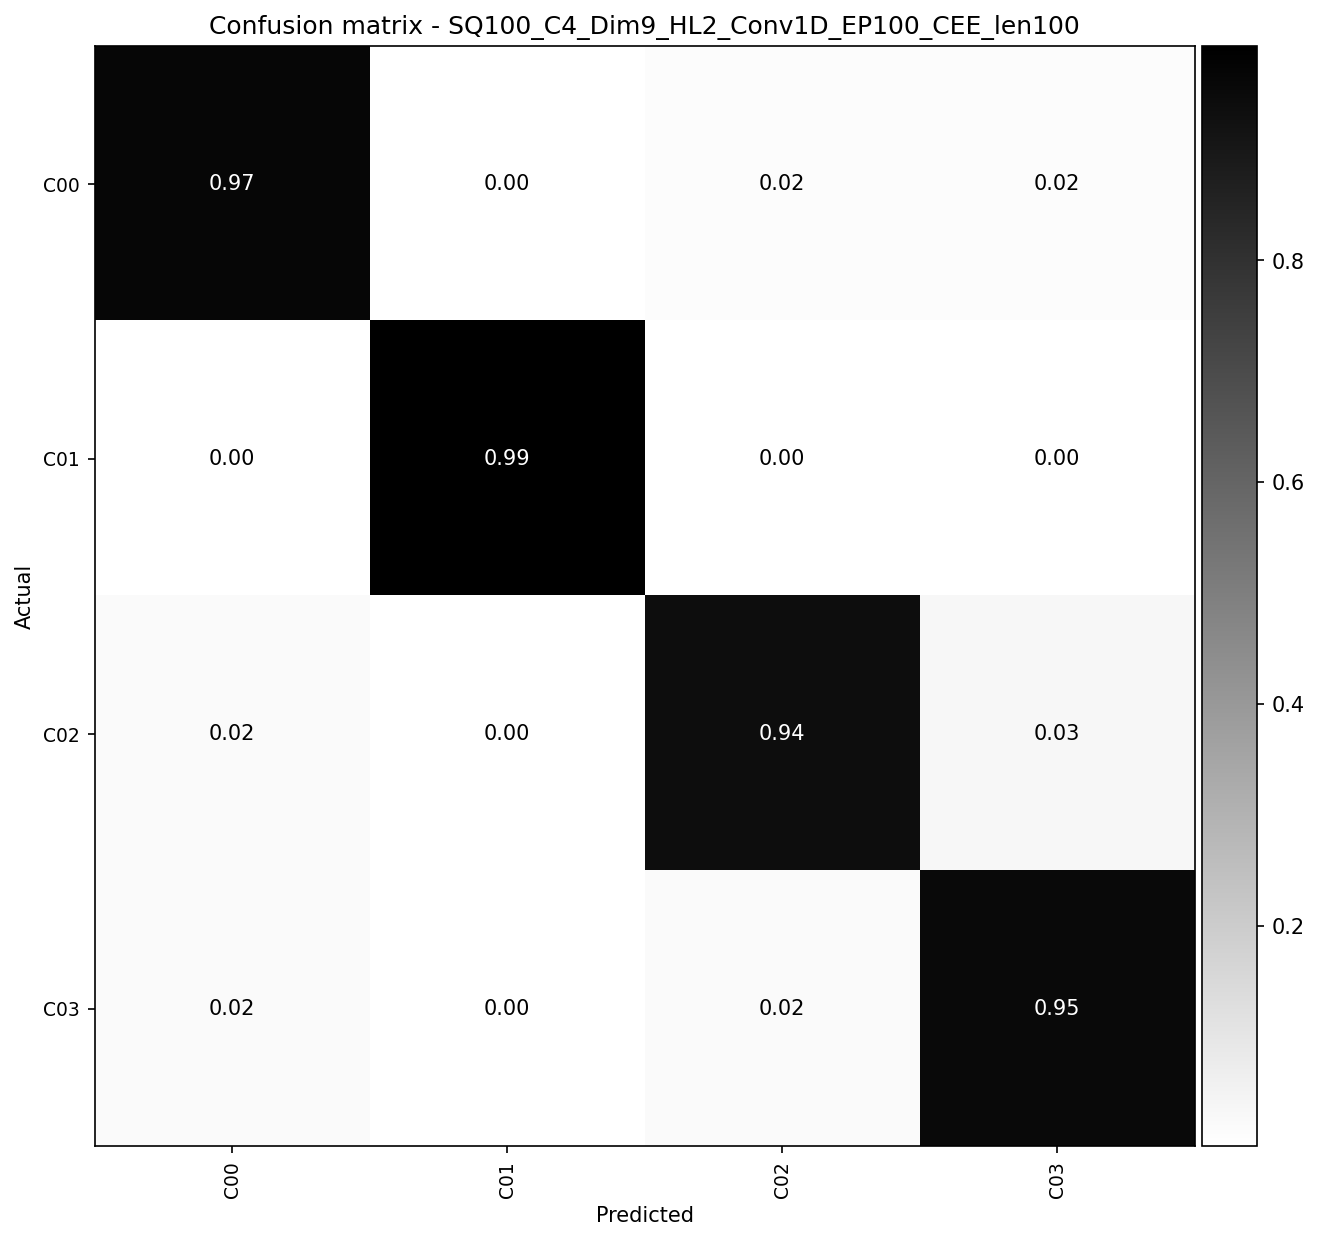

In [ ]:
fig_conf = plot_confusion_matrix3x(testy1, pred_test1, class_name, title='Confusion matrix - {}'.format(ttl1), normalize=True,
                                   figsize=(10,10), dpi=150, hide_classname = False, outdir=outDir, cmap = 'binary')

## t-SNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
emb_model = Model(model.input, model.layers[-2].output)
emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_input (InputLayer)   [(None, 100, 9)]          0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           896       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 64)               0     

In [ ]:
embedding = emb_model.predict(testX)
print(embedding.shape)

(6030, 64)


In [ ]:
print(testy.shape)
print(testy1.shape)

(6030, 4)
(6030,)


In [ ]:
%%time
proj = TSNE(n_components=2).fit_transform(embedding)

CPU times: user 1min 32s, sys: 752 ms, total: 1min 33s
Wall time: 48.3 s


In [ ]:
cmp = plt.get_cmap("tab10")

100%|██████████| 4/4 [00:00<00:00, 121.18it/s]

./out/n21_CL4_HL2_Conv1D_EP100_CEE_len100/embedding_SQ100_C4_Dim9_HL2_Conv1D_EP100_CEE_len100.png


./out/n21_CL4_HL2_Conv1D_EP100_CEE_len100/embedding_SQ100_C4_Dim9_HL2_Conv1D_EP100_CEE_len100.svg


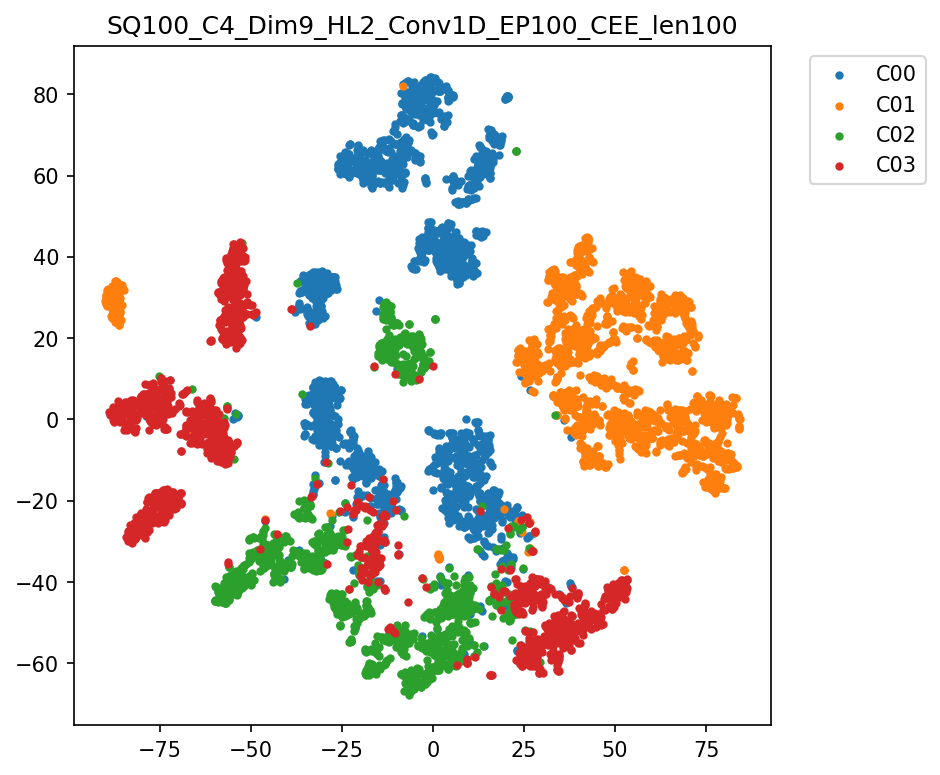

In [ ]:
plt.figure(figsize=(6,6), dpi=150)

for i in tqdm(range(n_outputs)):
    select_flag = testy1 == i
    plt_latent = proj[select_flag, :]
    plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp((i)), marker=".")
fnfig = "{}/embedding_{}.png".format(outDir, ttl1)#n_labeled_data
print(fnfig)
ttl2 = '{}'.format(ttl1)
plt.title(ttl2)
plt.gca().legend(class_name, bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(fnfig, bbox_inches = "tight")

fnfig = "{}/embedding_{}.svg".format(outDir, ttl1)#n_labeled_data
print(fnfig)
plt.savefig(fnfig, bbox_inches = "tight")